# <center>STATE OF THE ART - EMOTION DETECTION IN ART PORTRAITS</center>


In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [113]:
train_dir = "train"
test_dir = "test"
test_art = 'portraits'
final_test = 'final test'
krt_test = 'krt test'

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [114]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function = preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function = preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [115]:
#first small dataset we tested our model on
preprocess_fun = tf.keras.applications.densenet.preprocess_input

test_art_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function = preprocess_fun) 

test_art_generator = test_datagen.flow_from_directory(directory = test_art,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 8 images belonging to 1 classes.


In [116]:
#for big art portraits data set
preprocess_fun = tf.keras.applications.densenet.preprocess_input

finaltest_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function = preprocess_fun) 

finaltest_generator = finaltest_datagen.flow_from_directory(directory = final_test,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 866 images belonging to 2 classes.


In [117]:
#for katie, reva, tina portraits
preprocess_fun = tf.keras.applications.densenet.preprocess_input

krt_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function = preprocess_fun) 

krt_generator = finaltest_datagen.flow_from_directory(directory = krt_test,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 3 images belonging to 1 classes.


# <center>HELPER FUNCTIONS</center>

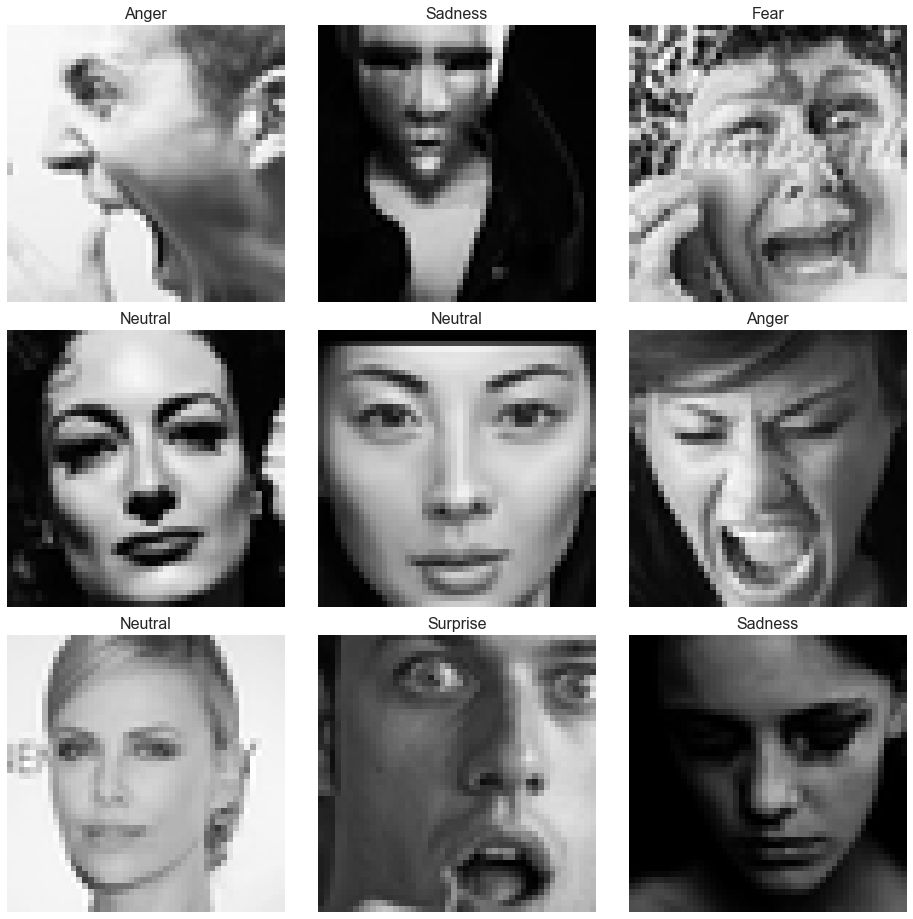

In [118]:
# Helper Functions

#to show one image with its label (emotion)
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
#to show nine images with its labels (emotions)
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

# <center>DATA DISTRIBUTION IN TRAINING DATA</center>

In [15]:
!pip install plotly

In [119]:
import plotly

In [122]:
import plotly.express as px

fig = px.bar(x = CLASS_LABELS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<a id="model"></a>
# <center> DenseNet169 TRANSFER LEARNING  </center>

In [37]:
#extracts features from input images
#given a dataset of images, extracts features that classify emotions
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top = False,
                                               weights = "imagenet")(inputs)
    
    return feature_extractor



def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

#compiles the model
#this is where the model learns to recognize emotions
def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

## Summary of model

In [38]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                             

## Training model with freezed layers of DenseNet169

In [39]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/30
359/359 [==============================] - 567s 2s/step - loss: 10.0120 - accuracy: 0.2450 - val_loss: 5.6219 - val_accuracy: 0.1681
Epoch 2/30
359/359 [==============================] - 593s 2s/step - loss: 3.5143 - accuracy: 0.3777 - val_loss: 2.3548 - val_accuracy: 0.4100
Epoch 3/30
359/359 [==============================] - 523s 1s/step - loss: 1.8560 - accuracy: 0.4560 - val_loss: 2.0990 - val_accuracy: 0.3188
Epoch 4/30
359/359 [==============================] - 1406s 4s/step - loss: 1.4354 - accuracy: 0.4981 - val_loss: 1.3300 - val_accuracy: 0.5267
Epoch 5/30
359/359 [==============================] - 543s 2s/step - loss: 1.3111 - accuracy: 0.5277 - val_loss: 1.2968 - val_accuracy: 0.5321
Epoch 6/30
359/359 [==============================] - 612s 2s/step - loss: 1.2504 - accuracy: 0.5505 - val_loss: 1.2765 - val_accuracy: 0.5304
Epoch 7/30
359/359 [==============================] - 527s 1s/step - loss: 1.2180 - accuracy: 0.5656 - val_loss: 1.2482 - val_accuracy: 0.55

## Fine Tuning

In [40]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index = True)

Epoch 1/20
359/359 [==============================] - 519s 1s/step - loss: 1.1629 - accuracy: 0.5928 - val_loss: 1.1644 - val_accuracy: 0.5802
Epoch 2/20
359/359 [==============================] - 535s 1s/step - loss: 1.1319 - accuracy: 0.6009 - val_loss: 1.1503 - val_accuracy: 0.5870
Epoch 3/20
359/359 [==============================] - 527s 1s/step - loss: 1.1250 - accuracy: 0.6058 - val_loss: 1.1393 - val_accuracy: 0.5907
Epoch 4/20
359/359 [==============================] - 4174s 12s/step - loss: 1.1096 - accuracy: 0.6088 - val_loss: 1.1311 - val_accuracy: 0.5929
Epoch 5/20
359/359 [==============================] - 519s 1s/step - loss: 1.1033 - accuracy: 0.6105 - val_loss: 1.1267 - val_accuracy: 0.5943
Epoch 6/20
359/359 [==============================] - 561s 2s/step - loss: 1.1038 - accuracy: 0.6125 - val_loss: 1.1223 - val_accuracy: 0.5948
Epoch 7/20
359/359 [==============================] - 567s 2s/step - loss: 1.0865 - accuracy: 0.6172 - val_loss: 1.1181 - val_accuracy: 0.59

## Training plots

In [41]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True)
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [42]:
x = px.line(data_frame= history , 
            y= ["loss" , "val_loss"] , markers = True)
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

<a id="vis"></a>
# <center> Visualizing Results </center> 

## Model Evaluation

In [43]:
#evaluate the model on the test data set of human faces
model.evaluate(test_generator)

#make predictions on the test data set of human faces
preds = model.predict(test_generator)

#convert predictions into a numpy array
y_preds = np.argmax(preds , axis = 1 )

#convert test labels into a numpy array
y_test = np.array(test_generator.labels)

113/113 [==============================] - 27s 243ms/step - loss: 1.1031 - accuracy: 0.6091


## Confusion Matrix

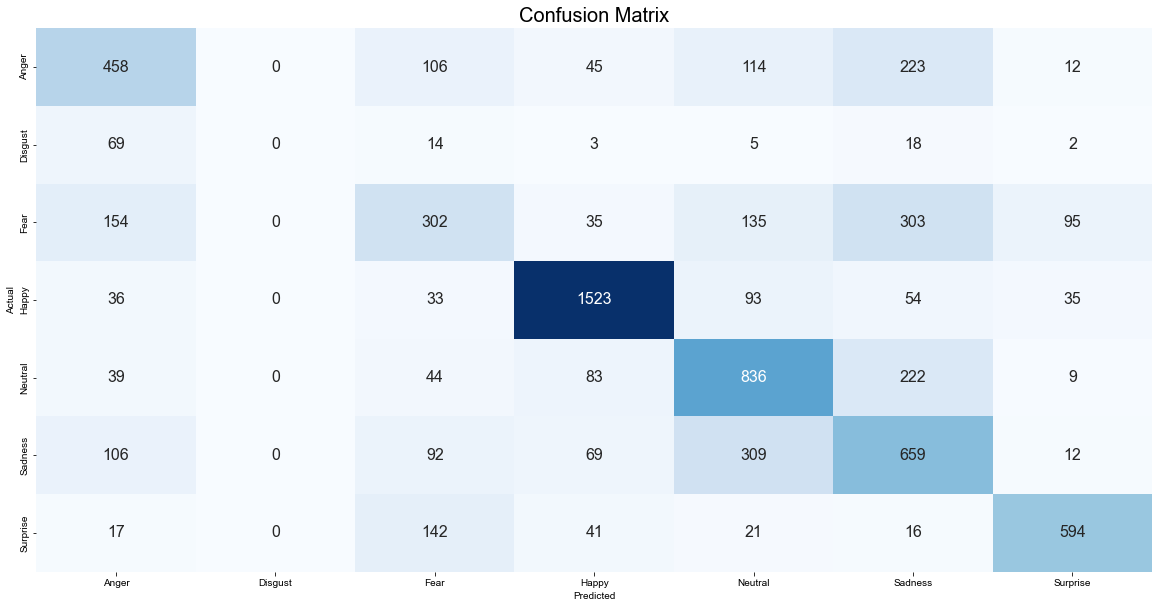

In [44]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Classification Report 

In [45]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.52      0.48      0.50       958
           1       0.00      0.00      0.00       111
           2       0.41      0.29      0.34      1024
           3       0.85      0.86      0.85      1774
           4       0.55      0.68      0.61      1233
           5       0.44      0.53      0.48      1247
           6       0.78      0.71      0.75       831

    accuracy                           0.61      7178
   macro avg       0.51      0.51      0.50      7178
weighted avg       0.60      0.61      0.60      7178



## Multiclass AUC Curve

ROC AUC score: 0.9057812422729711


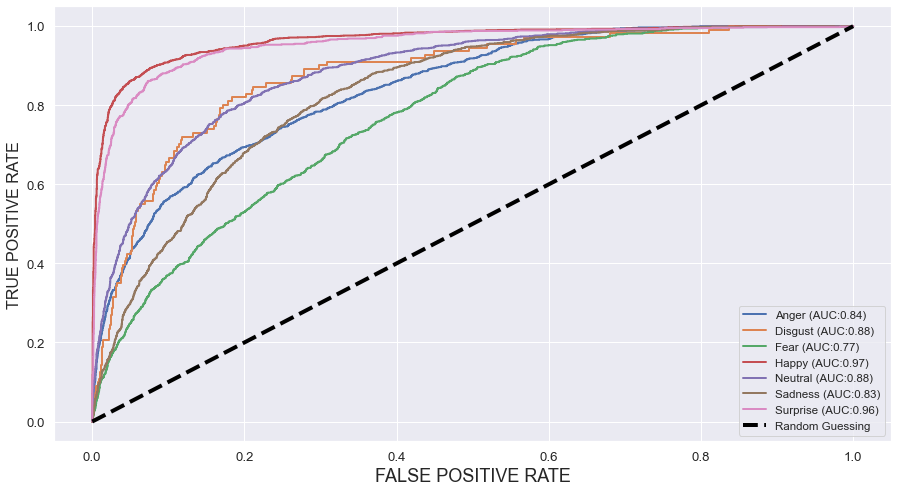

In [46]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [47]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.8754217072242937


## Cropping Faces from Portraits

In [60]:
!pip install mtcnn

In [51]:
import mtcnn
from mtcnn.mtcnn import MTCNN
print(mtcnn.__version__)

0.1.0


In [52]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [55]:
# example of face detection with mtcnn
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(48, 48)):
    # load image from file
    pixels = pyplot.imread(filename)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

In [56]:
import os

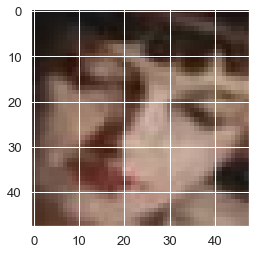

In [59]:
# load the photo and extract the face
pixels = extract_face('agnes-goodsir_5.jpg')
image = Image.fromarray(pixels, 'RGB')
image.save("agnes-goodsir_5.jpg")
# plot the extracted face
pyplot.imshow(pixels)
# show the plot
pyplot.show()

In [103]:
# assign directory
directory = 'Images'
 
# iterate over portraits and extract just faces
for pic_name in os.listdir(directory):
    try:
        pixels = extract_face("Images/" + pic_name)
        image = Image.fromarray(pixels, 'RGB')
        image.save("test art/" + pic_name)
    except IndexError:
        pass

In [73]:
#extract faces for krt portraits
for pic_name in os.listdir('krt test/test'):
    try:
        pixels = extract_face("krt test/test/" + pic_name)
        image = Image.fromarray(pixels, 'RGB')
        image.save("krt portraits/" + pic_name)
    except IndexError:
        pass

## Using Model on Art Portraits

In [51]:
#use model on art portraits
model.evaluate(test_art_generator)

#make predictions on art portraits
art_preds = model.predict(test_art_generator)

#convert predictions into numpy array --> an array of nums eg. [1, 0, 7, 6, ]
predicted_class_indices = np.argmax(art_preds,axis=1)


art_test = np.array(test_art_generator.labels)

1/1 [==============================] - 0s 87ms/step - loss: 21.3013 - accuracy: 0.0000e+00


In [52]:
#to get class labels corresponding to predictions 
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [53]:
predictions

['happy',
 'fearful',
 'sad',
 'surprised',
 'fearful',
 'neutral',
 'neutral',
 'sad']

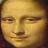

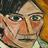

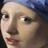

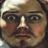

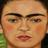

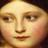

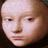

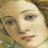

In [29]:
#above predictions are for images below
from IPython.display import Image
from IPython.display import display
for pic in os.listdir('portraits/test'):
    x = Image(filename = pic)
    display(x)

In [108]:
#use model on art portraits
model.evaluate(finaltest_generator)

#make predictions on art portraits
art_preds1 = model.predict(finaltest_generator)

#convert predictions into numpy array --> an array of nums eg. [1, 0, 7, 6, ]
predicted_class_indices1 = np.argmax(art_preds1,axis=1)

14/14 [==============================] - 5s 322ms/step - loss: 23.6945 - accuracy: 0.0589


In [111]:
#to get class labels corresponding to predictions 
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices1]

In [113]:
predictions1

['sad',
 'neutral',
 'sad',
 'neutral',
 'neutral',
 'angry',
 'neutral',
 'neutral',
 'angry',
 'neutral',
 'angry',
 'neutral',
 'sad',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'happy',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'happy',
 'sad',
 'neutral',
 'neutral',
 'happy',
 'neutral',
 'happy',
 'neutral',
 'neutral',
 'sad',
 'neutral',
 'neutral',
 'sad',
 'sad',
 'neutral',
 'happy',
 'neutral',
 'sad',
 'sad',
 'sad',
 'neutral',
 'neutral',
 'angry',
 'neutral',
 'fearful',
 'neutral',
 'happy',
 'neutral',
 'happy',
 'neutral',
 'angry',
 'neutral',
 'sad',
 'angry',
 'neutral',
 'sad',
 'sad',
 'neutral',
 'sad',
 'neutral',
 'neutral',
 'angry',
 'neutral',
 'neutral',
 'happy',
 'angry',
 'happy',
 'sad',
 'neutral',
 'neutral',
 'angry',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'sad',
 'angry',
 'neutral',
 'sad',
 'neutral',
 'neutral',
 'neutral',
 'sad',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neut

## Using model on our faces

In [92]:
#use model on art portraits
model.evaluate(krt_generator)

#make predictions on art portraits
krt_preds = model.predict(krt_generator)

#convert predictions into numpy array --> an array of nums eg. [1, 0, 7, 6, ]
krt_predicted_class_indices = np.argmax(krt_preds,axis=1)


art_test = np.array(test_art_generator.labels)

1/1 [==============================] - 0s 183ms/step - loss: 26.5540 - accuracy: 0.0000e+00


In [93]:
#to get class labels corresponding to krt predictions 
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
krt_predictions = [labels[k] for k in krt_predicted_class_indices]

In [94]:
krt_predictions

['sad', 'happy', 'fearful']

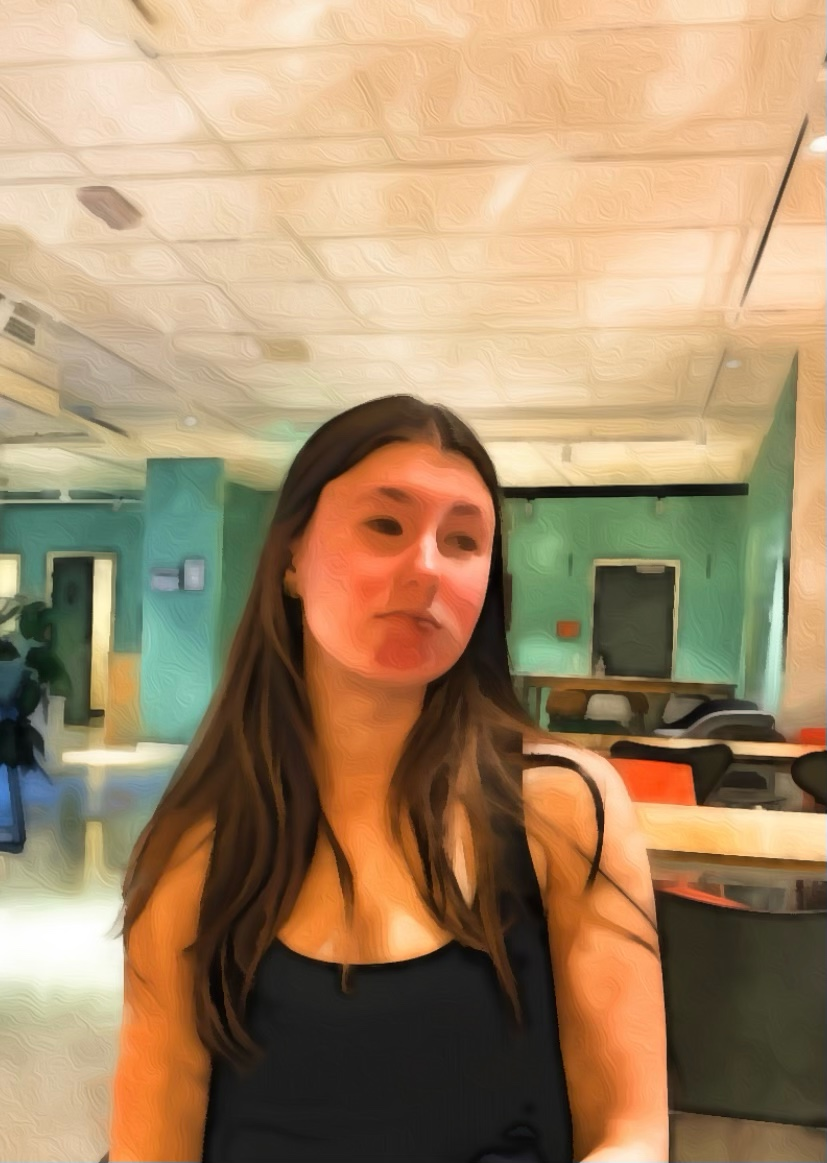

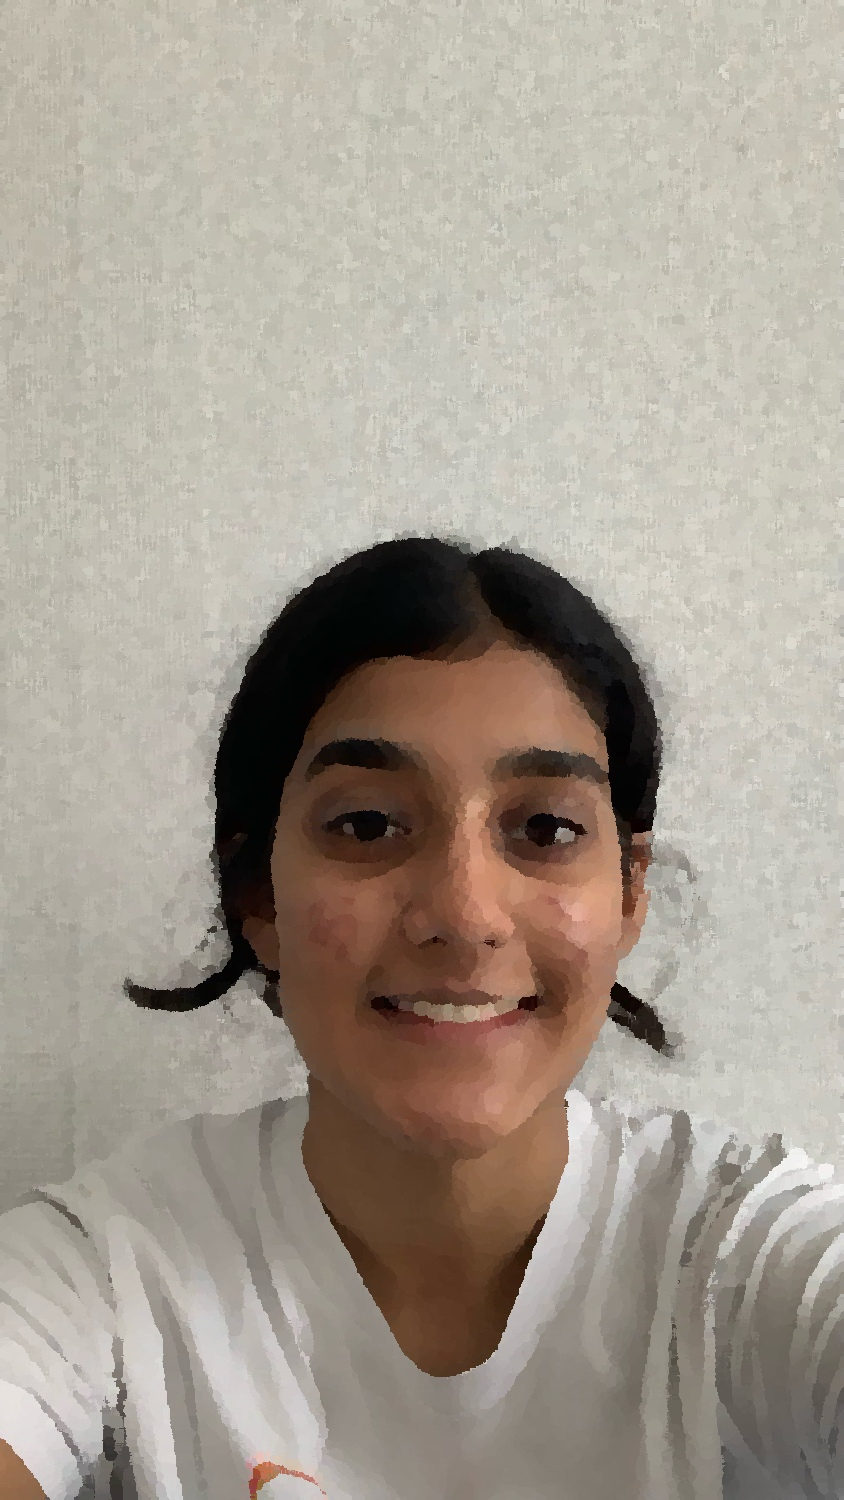

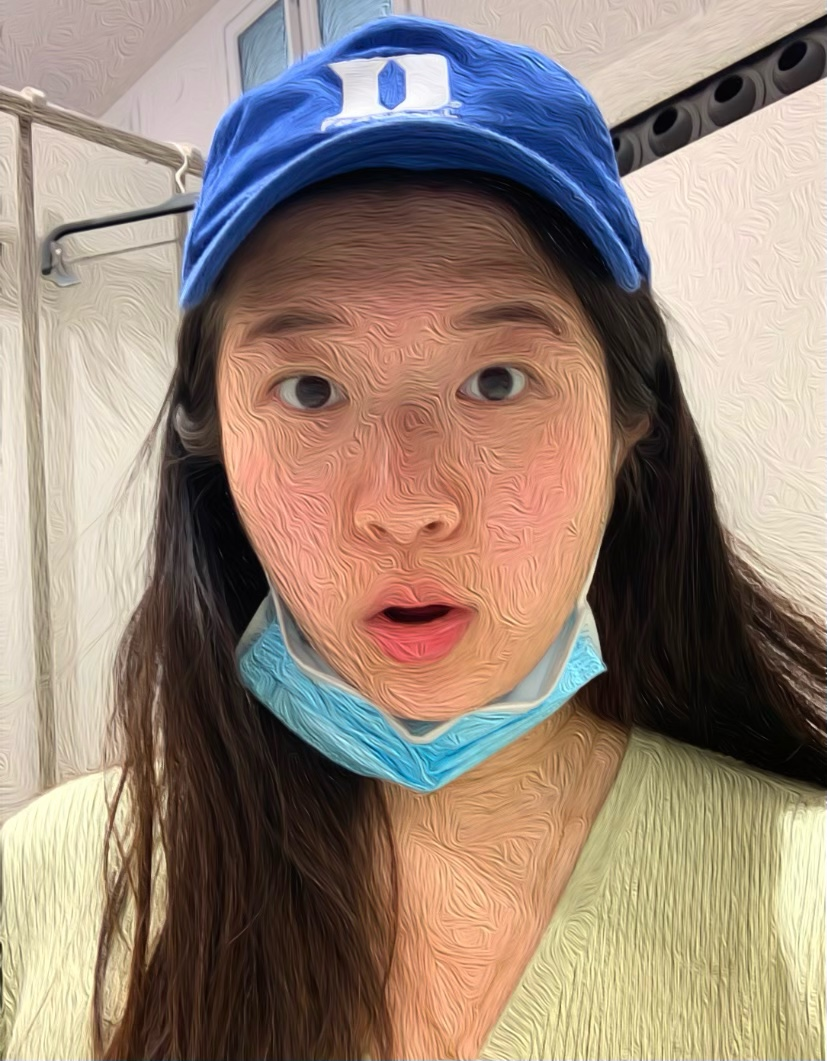

In [98]:
from IPython.display import Image
from IPython.display import display
for pic in os.listdir('krt portraits'):
    x = Image(filename = pic, width = 60, height = 100)
    display(x)

## Visualizing Predictions of Portrait Dataset

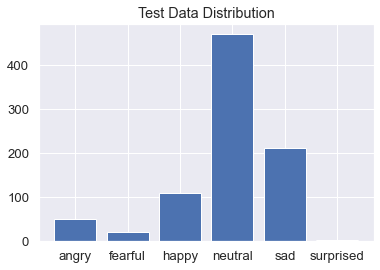

In [119]:
keys, counts = np.unique(predictions1, return_counts=True)

plt.bar(keys, counts)
plt.title("Test Data Distribution")
plt.show()